In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from s3fs.core import S3FileSystem
from tqdm import tqdm

def draw_screen_poly(lats, lons, map):
    x, y = map( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), 
                   edgecolor="black",
                   facecolor="None",
                   lw=2.5)
    plt.gca().add_patch(poly)

def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)
        # Midwest US
    # https://en.wikipedia.org/wiki/Module:Location_map/data/USA_Midwest
    lats_mw_us = [ 36.15, 49.5, 49.5, 36.15 ]
    lons_mw_us = [ -95, -95, -75, -75 ]

    # Europe
    lats_eu = [ 40, 50, 50, 40 ]
    lons_eu = [ 15, 15, 30, 30 ]

    # India https://link.springer.com/article/10.1007/s12524-011-0119-x
    # Just say central India and the indo gangetic plains 
    lats_in = [ 18, 25, 25, 18 ]
    lons_in = [ 75, 75, 87, 87 ]

    # https://baike.baidu.com/item/%E5%8D%8E%E5%8C%97%E5%B9%B3%E5%8E%9F
    lats_ch = [ 32, 45, 45, 32 ]
    lons_ch = [ 110, 110, 123, 123 ]
    
    
    plt.figure(figsize=(16, 7))
    map = Basemap()
    map.drawcoastlines()
    map.drawcoastlines()
    map.readshapefile('../../5_event_analysis/shapefile/maps', 'maps')
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    draw_screen_poly(lats_mw_us, lons_mw_us, map)
    draw_screen_poly(lats_eu, lons_eu, map)
    draw_screen_poly(lats_in, lons_in, map)
    draw_screen_poly(lats_ch, lons_ch, map)
    
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    #plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

## Save the necessary files

In [2]:
%%time

s3 = S3FileSystem()
validation_path = "/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/"
save_dir = "S3://uhws/UHWs_CESM/model-validation-diff/"
rmse_by_lat_lon_ls = []

for i in tqdm(range(2,34)):
        member = (str(i).zfill(3))
        #print("member:",member)

        df_2006=pd.read_csv("/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/2006/"+member+"_ens.csv")
        rmse_by_lat_lon_2006 = df_2006.groupby(["lat","lon"])\
                                   .apply(lambda df_2006: 
                                          np.mean(df_2006[member]-df_2006["TREFMXAV_U"]))

        df_2061=pd.read_csv("/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/2061/"+member+"_ens.csv")
        rmse_by_lat_lon_2061 = df_2061.groupby(["lat","lon"])\
                                   .apply(lambda df_2061: 
                                          np.mean(df_2061[member]-df_2061["TREFMXAV_U"]))
        
        rmse_by_lat_lon_ls.append(rmse_by_lat_lon_2061 - rmse_by_lat_lon_2006)
        
        del df_2006, df_2061, rmse_by_lat_lon_2006, rmse_by_lat_lon_2061
        gc.collect()
        
rmse_by_lat_lon=pd.concat(rmse_by_lat_lon_ls,axis=1)
rmse_by_lat_lon.to_csv(save_dir+"rmse_by_lat_lon.csv")

100%|██████████| 32/32 [16:20<00:00, 30.63s/it]


CPU times: user 14min 44s, sys: 1min 30s, total: 16min 15s
Wall time: 16min 21s


## visualization

In [8]:
s3 = S3FileSystem()
validation_path = "/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/"
save_dir = "S3://uhws/UHWs_CESM/model-validation-diff/"
df = pd.read_csv(save_dir+"rmse_by_lat_lon.csv")
df_mean = df.set_index(["lat","lon"]).mean(axis=1)

,lat,lon,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
count,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,...,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,-0.007899,-0.001134,0.001191,0.015226,0.009033,-0.004017,-0.005894,-0.007671,...,0.005348,0.007614,0.004365,0.003627,-0.000251,0.008702,0.005966,-0.008354,0.013004,-0.002851
std,25.646228,111.895429,0.075839,0.077924,0.073857,0.073946,0.073608,0.074494,0.079548,0.075712,...,0.080427,0.076536,0.082987,0.075926,0.071599,0.076344,0.077022,0.073885,0.079690,0.075527
min,-54.188499,0.000000,-0.398359,-0.529629,-0.341525,-0.380412,-0.564187,-0.551252,-0.487688,-0.462061,...,-0.740648,-0.375084,-0.548219,-0.480948,-0.451404,-0.457421,-0.381190,-0.434872,-0.492405,-0.726405
25%,8.952900,36.250000,-0.044923,-0.031434,-0.036200,-0.021548,-0.026125,-0.035787,-0.042485,-0.041530,...,-0.034708,-0.029169,-0.034813,-0.031625,-0.030031,-0.031501,-0.026367,-0.037473,-0.024144,-0.037195
50%,29.685900,100.000000,-0.007209,0.001513,-0.000618,0.013451,0.004923,-0.000340,-0.007829,-0.006831,...,-0.001174,0.002359,0.001965,0.003465,0.002341,0.005300,0.005742,-0.002895,0.010431,-0.003528
75%,42.879601,260.000000,0.031449,0.036078,0.036819,0.051814,0.041851,0.031378,0.032122,0.028829,...,0.036531,0.040514,0.040705,0.038467,0.036220,0.042338,0.041897,0.027502,0.051778,0.032497
max,70.209396,358.750000,0.464654,0.462539,0.423520,0.442397,0.387689,0.397877,0.533710,0.395484,...,0.505735,0.559684,0.507655,0.486965,0.366714,0.548795,0.548688,0.437127,0.525136,0.381778


count    4439.000000
mean        0.000846
std         0.009589
min        -0.040876
25%        -0.005092
50%         0.000423
75%         0.006312
max         0.052918
dtype: float64

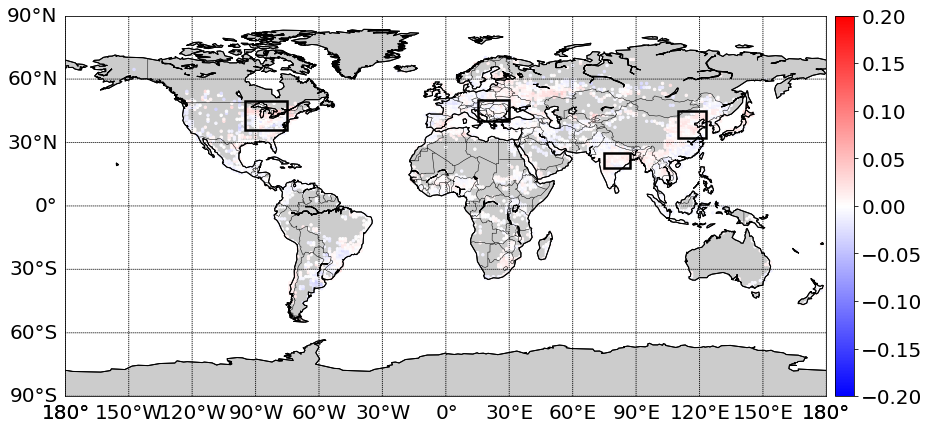

In [10]:
display(df.describe())
display(df_mean.describe())
global_map_plot(df_mean.reset_index(), 0, -0.2, 0.2, "bwr","")